# Bank Customer Segmentation

In this kernel I will perform segmentation of German bank customers. The first step is to read necessary libraries. We will use: 
* [pandas](https://pandas.pydata.org/) - to manipulate data frames
* [numpy](http://www.numpy.org/) - providing linear algebra
* [seaborm](https://seaborn.pydata.org/) - to create nice visualizations
* [matplotlib](https://matplotlib.org/) - basic tools for visualizations
* [scikit-learn](https://scikit-learn.org/stable/) - machine learning library

From sklearn, I will import necessary pre-processing tools and two clustering algorithms: [KMeans](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html) and [Affinity Propagation](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.AffinityPropagation.html).


In [42]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, AffinityPropagation
import warnings
warnings.filterwarnings("ignore")

Reading the raw data 

In [43]:
data = pd.read_csv("/home/andre/Desktop/german_credit_data.csv")

A visual control of the first five rows.

In [44]:
# Return a tuple representing the dimensionality of the DataFrame.
data.shape

(1000, 10)

### The relevant attributes of this dataset are:

- Age (numeric)
- Sex (text: male, female)
- Job (numeric: 0 - unskilled and non-resident, 1 - unskilled and resident, 2 - skilled, 3 - highly skilled)
- Housing (text: own, rent, or free)
- Saving accounts (text - little, moderate, quite rich, rich)
- Checking account (numeric, in DM - Deutsch Mark)
- Credit amount (numeric, in DM)
- Duration (numeric, in month)
- Purpose (text: car, furniture/equipment, radio/TV, domestic appliances, repairs, education, business, vacation/others)

In [45]:
data.head()

,Unnamed: 0,Age,Sex,Job,Housing,Saving accounts,Checking account,Credit amount,Duration,Purpose
0,0,67,male,2,own,NaN,little,1169,6,radio/TV
1,1,22,female,2,own,little,moderate,5951,48,radio/TV
2,2,49,male,1,own,little,NaN,2096,12,education
3,3,45,male,2,free,little,little,7882,42,furniture/equipment
4,4,53,male,2,free,little,little,4870,24,car


It looks that the first column is simply an index which we can delete. I will check how many missing values are in each column and of what data types they are. 

In [46]:
data.drop(data.columns[0], inplace=True, axis=1)
print("Database has {} obserwations (customers) and {} columns (attributes).".format(data.shape[0],data.shape[1]))
print("\n")
print("Missing values in each column:\n{}".format(data.isnull().sum()))
print("\n")
print("Columns data types:\n{}".format(data.dtypes))

Database has 1000 obserwations (customers) and 9 columns (attributes).


Missing values in each column:
Age                   0
Sex                   0
Job                   0
Housing               0
Saving accounts     183
Checking account    394
Credit amount         0
Duration              0
Purpose               0
dtype: int64


Columns data types:
Age                  int64
Sex                 object
Job                  int64
Housing             object
Saving accounts     object
Checking account    object
Credit amount        int64
Duration             int64
Purpose             object
dtype: object


Out of 8 columns 2 contain missing values. Probably these are customers who don’t have one of these two accounts. 

Generally, there are 3 numeric variables and 5 categorical ones.

Now, I will check how many, and what are the possible (unique) values in each categorical column.

In [47]:
n_unique = data.nunique()
print("Number of unique values:\n{}".format(n_unique))

Number of unique values:
Age                  53
Sex                   2
Job                   4
Housing               3
Saving accounts       4
Checking account      3
Credit amount       921
Duration             33
Purpose               8
dtype: int64


In [48]:
#### Parameters of select_dtypes()
#### include, excludescalar or list-like
#### A selection of dtypes or strings to be included/excluded. At least one of these parameters must be supplied.

In [49]:
# select_dtypes(). Return a subset of the DataFrame’s columns based on the column dtypes.
print("Unique values in each categorical column:")
for col in data.select_dtypes(include=[object]):
    print(col,":", data[col].unique())

Unique values in each categorical column:
Sex : ['male' 'female']
Housing : ['own' 'free' 'rent']
Saving accounts : [nan 'little' 'quite rich' 'rich' 'moderate']
Checking account : ['little' 'moderate' nan 'rich']
Purpose : ['radio/TV' 'education' 'furniture/equipment' 'car' 'business'
 'domestic appliances' 'repairs' 'vacation/others']


In [50]:
# Visualizing the values
data.select_dtypes(include=[object])
# To select strings you must use the object dtype, but note that this will return all object dtype columns

,Sex,Housing,Saving accounts,Checking account,Purpose
0,male,own,NaN,little,radio/TV
1,female,own,little,moderate,radio/TV
2,male,own,little,NaN,education
3,male,free,little,little,furniture/equipment
4,male,free,little,little,car
...,...,...,...,...,...
995,female,own,little,NaN,furniture/equipment
996,male,own,little,little,car
997,male,own,little,NaN,radio/TV
998,male,free,little,little,radio/TV


**Exploratory Data Analysis**

Below I will define a function which will generate plots for three numeric variables with stratification by selected categorical column.

In [51]:
def scatters(data, h=None, pal=None):
    fig, (ax1, ax2, ax3) = plt.subplots(3,1, figsize=(8,8))
    sns.scatterplot(x="Credit amount",y="Duration", hue=h, palette=pal, data=data, ax=ax1)
    sns.scatterplot(x="Age",y="Credit amount", hue=h, palette=pal, data=data, ax=ax2)
    sns.scatterplot(x="Age",y="Duration", hue=h, palette=pal, data=data, ax=ax3)
    plt.tight_layout()

At the beginning let’s look at scatter plots our 3 numerical variables stratified by sex.

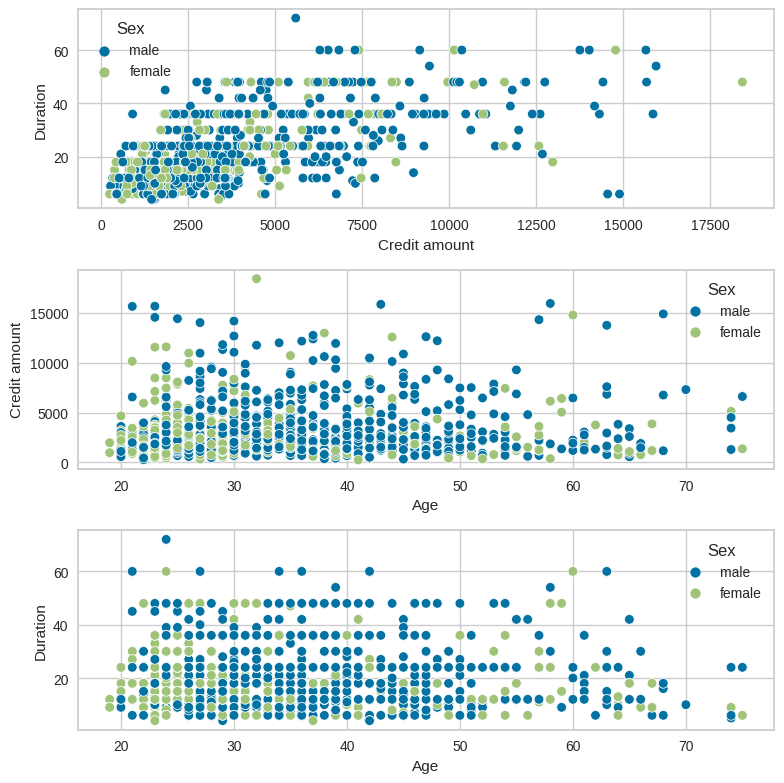

In [52]:
scatters(data, h="Sex")

The general impression is that women tend to be younger than men, however, the top plot shows that there is no clear difference between men and women in terms of amount and duration of the credit. From visual inspection, it seems that there is some positive correlation between duration and amount of credit, what makes sense. 

Let’s check the linear correlation between credit amount and duration

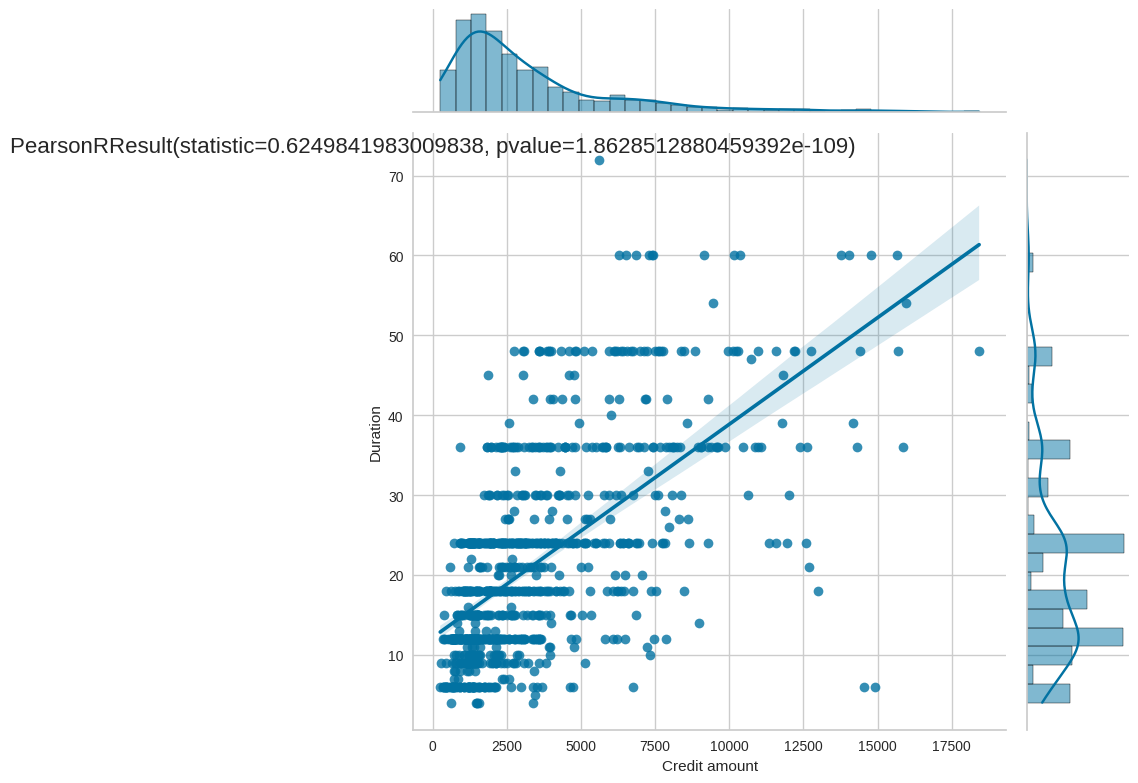

In [53]:
import scipy.stats as stats
# jointplot(). Draw a plot of two variables with bivariate and univariate graphs.
r1 = sns.jointplot(x="Credit amount",y="Duration", data=data, kind="reg", height=8)
# Parameter kind{ “scatter” | “kde” | “hist” | “hex” | “reg” | “resid” }. Kind of plot to draw. 
#r1.annotate(stats.pearsonr) # Annotate the point xy with text text. Nevertheless, that method was deprecated (in 0.9) and removed (in 0.11).
# Alternative to do this code: r1.annotate(stats.pearsonr)
plt.text(0, 73, stats.pearsonr(data['Credit amount'],data['Duration']), fontsize=16, ha='center')
plt.show()

The plot above shows a linear correlation with Pearson value of 0.62 and very small p-value (There is no statistical differences).  
That make’s sense because usually, people take bigger credits for longer periods.  Below I will analyse linear regression plots with various categorisations.

In [54]:
# Visualizing p-value without scientific notation. This is really a very small number. 
p_value = 1.8628512880459392e-109
print('%.112f' % p_value)
# 

0.0000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000001863


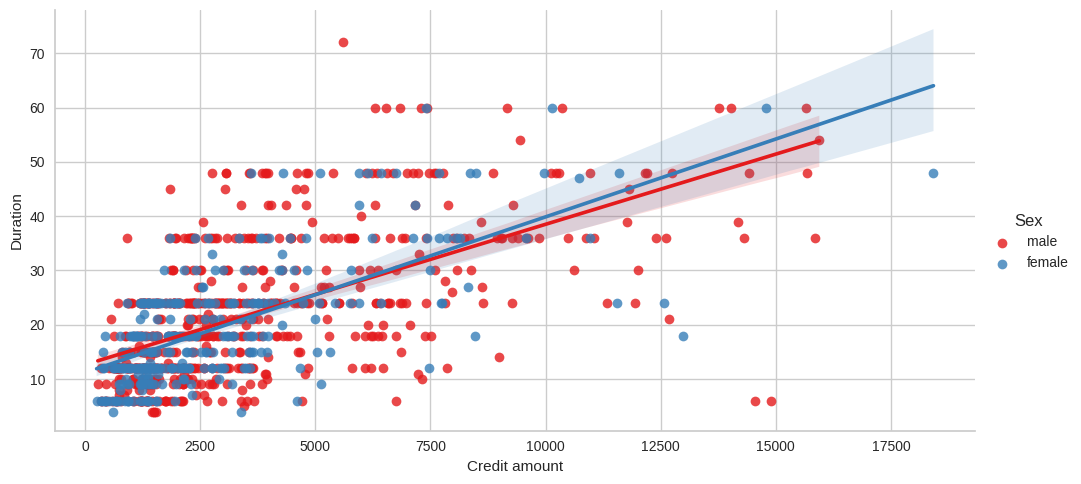

In [55]:
# lmplot(). Plot data and regression model fits across a FacetGrid.
sns.lmplot(x="Credit amount",y="Duration", hue="Sex", data=data, palette="Set1", aspect=2)
plt.show()

The plot above indicates that there is no significant difference between men and women.

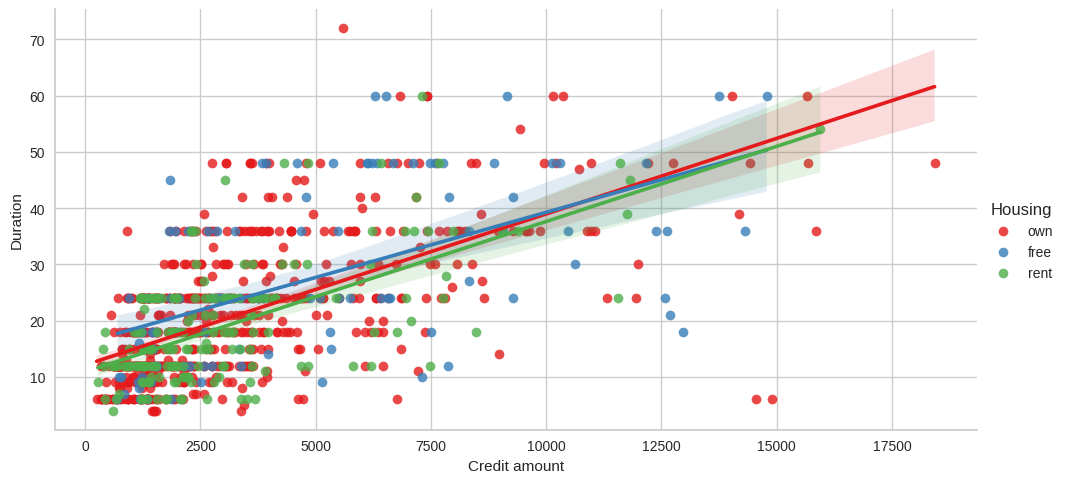

In [56]:
sns.lmplot(x="Credit amount",y="Duration", hue="Housing", data=data, palette="Set1", aspect=2)
plt.show()

The plot above shows similarly that there is no diference betwen housing categories.

Below I will show “business” area where granted the biggest amount of credits. 

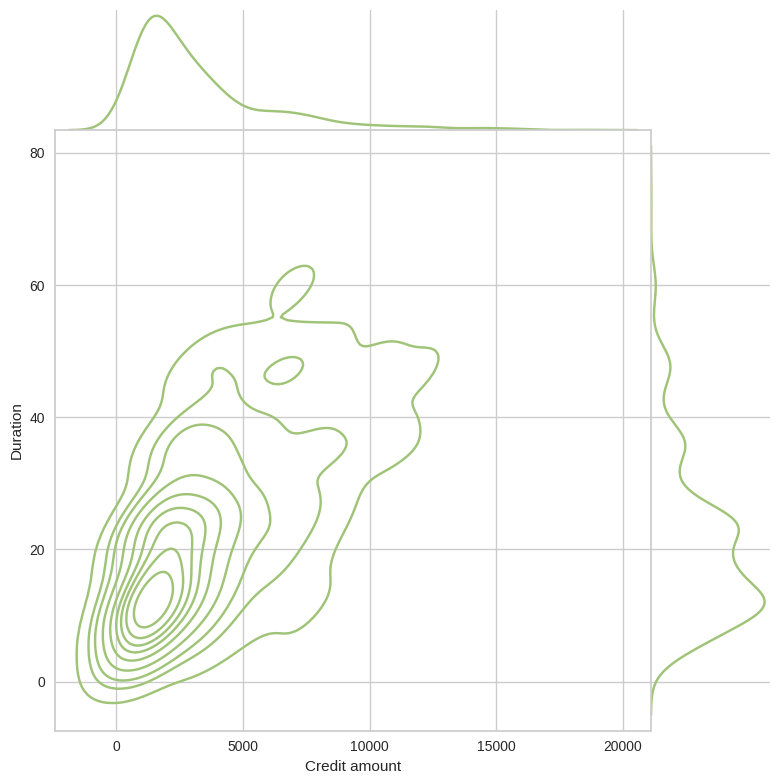

In [57]:
sns.jointplot(x="Credit amount",y="Duration", data=data, kind="kde", space=0, color="g",  height=8)
plt.show()

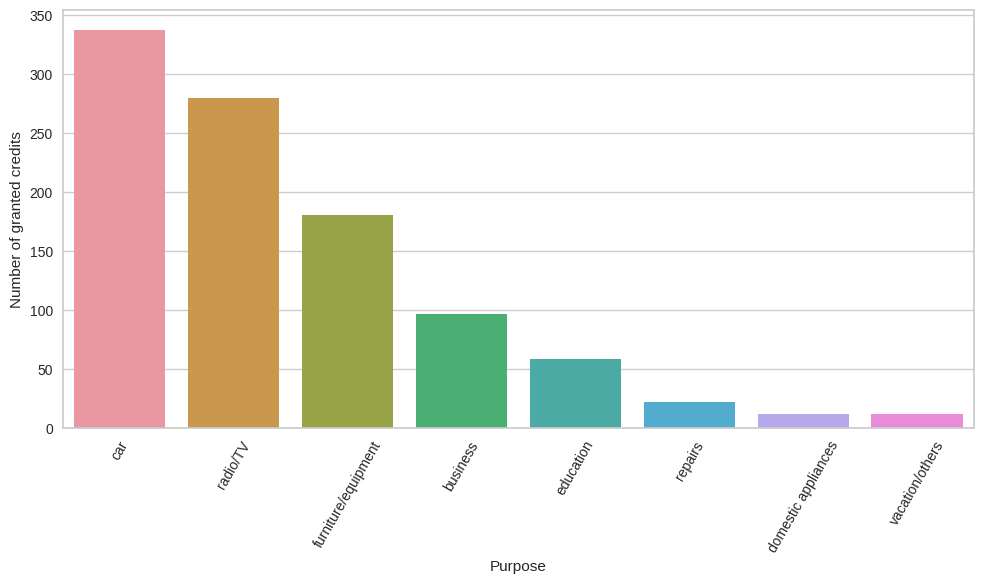

In [58]:
# groupby(). Group DataFrame using a mapper or by a Series of columns.
# groupby(). A groupby operation involves some combination of splitting the object, applying a function, and combining the results. This can be used to group large amounts of data and compute operations on these groups.
n_credits = data.groupby("Purpose")["Age"].count().rename("Count").reset_index()
n_credits.sort_values(by=["Count"], ascending=False, inplace=True)

plt.figure(figsize=(10,6))
bar = sns.barplot(x="Purpose",y="Count",data=n_credits)
bar.set_xticklabels(bar.get_xticklabels(), rotation=60) # Prevents x-axis labels from overlapping each other.
plt.ylabel("Number of granted credits")
plt.tight_layout()

The barplot above shows how many credits were granted for various purposes. Most of credits were granted for car and radio/TV.

Now I will generate boxplots for detailed analysis of categorical variables.

In [59]:
def boxes(x,y,h,r=45):
    fig, ax = plt.subplots(figsize=(10,6))
    box = sns.boxplot(x=x,y=y, hue=h, data=data)
    box.set_xticklabels(box.get_xticklabels(), rotation=r)
    fig.subplots_adjust(bottom=0.2) # subplots_adjust. Adjust the subplot layout parameters.
    # Parameter bottom of subplots_adjust. The position of the bottom edge of the subplots, as a fraction of the figure height.
    plt.tight_layout()

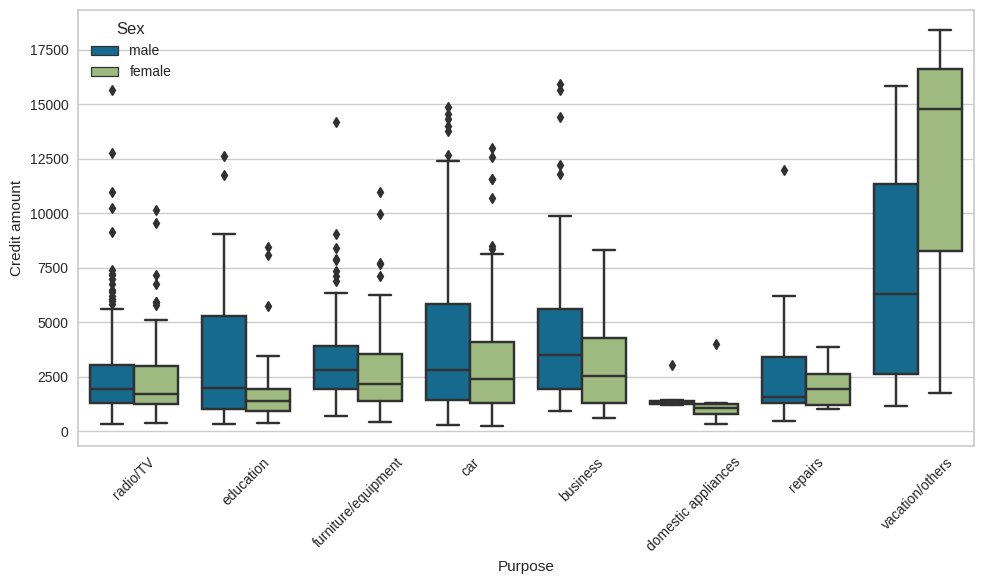

In [60]:
boxes("Purpose","Credit amount","Sex")

The plot above shows that the biggest amounts are taken for vacations/others, the smallest for domestic appliances. Most of them have outliers on the upper side of the boxes (higher amounts). In most of the cases there is no difference between men and women, despite category vacation/others. But one must remember that there was very little number of credits granted in this category. 

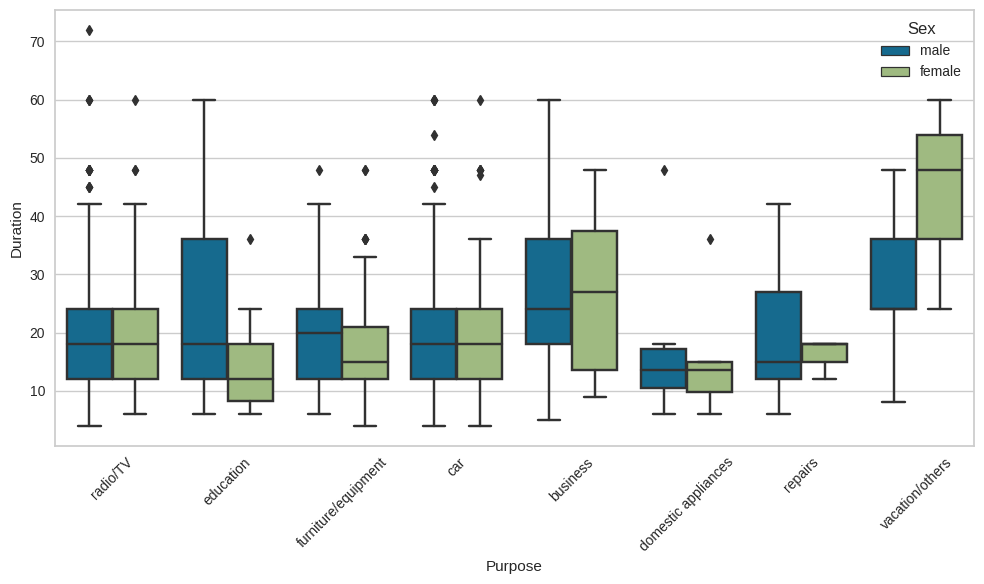

In [61]:
boxes("Purpose","Duration","Sex")

The boxplot above indicates that generally there is no difference in credit duration between men and women. We can’t see also clear trend between categories with observations that the shortest duration is for domestic appliances.  It makes sense as it is in agreement with insights from the previous graph (credit amount) – in this category, there are the lowest amounts of credits.

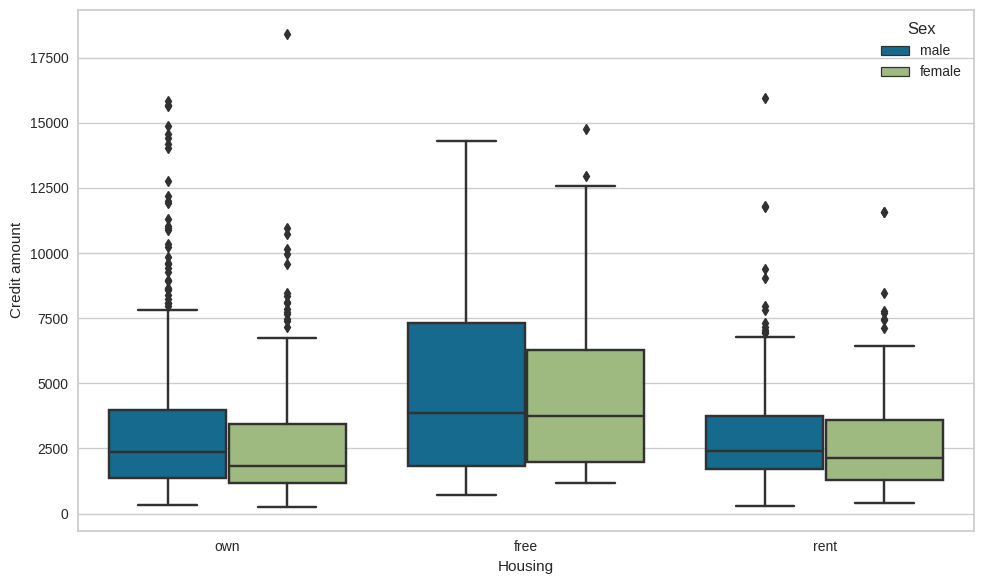

In [62]:
boxes("Housing","Credit amount","Sex",r=0)

In terms of housing category, there is no big difference despite people having “free” housing tend to take slightly bigger credit amounts.

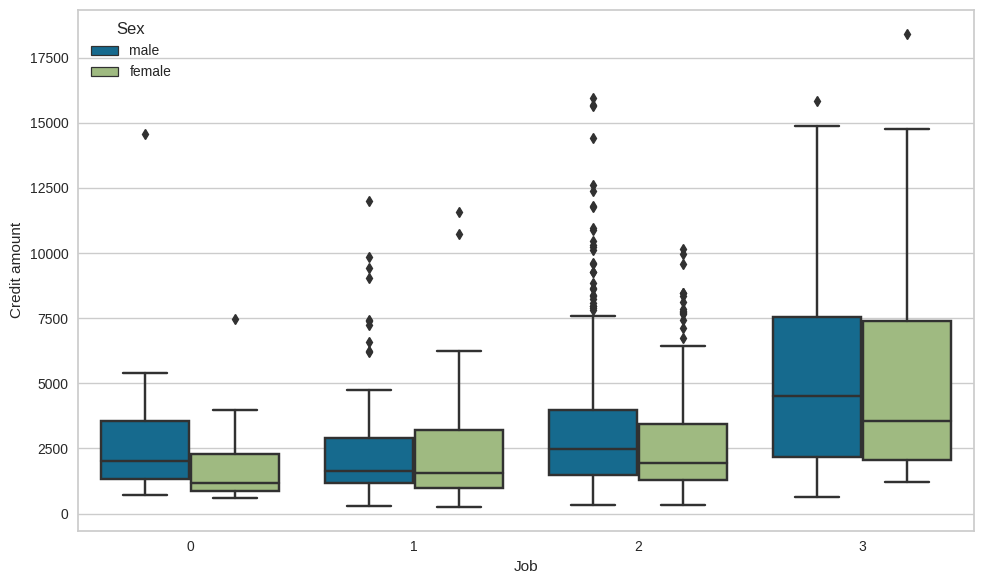

In [63]:
boxes("Job","Credit amount","Sex",r=0)

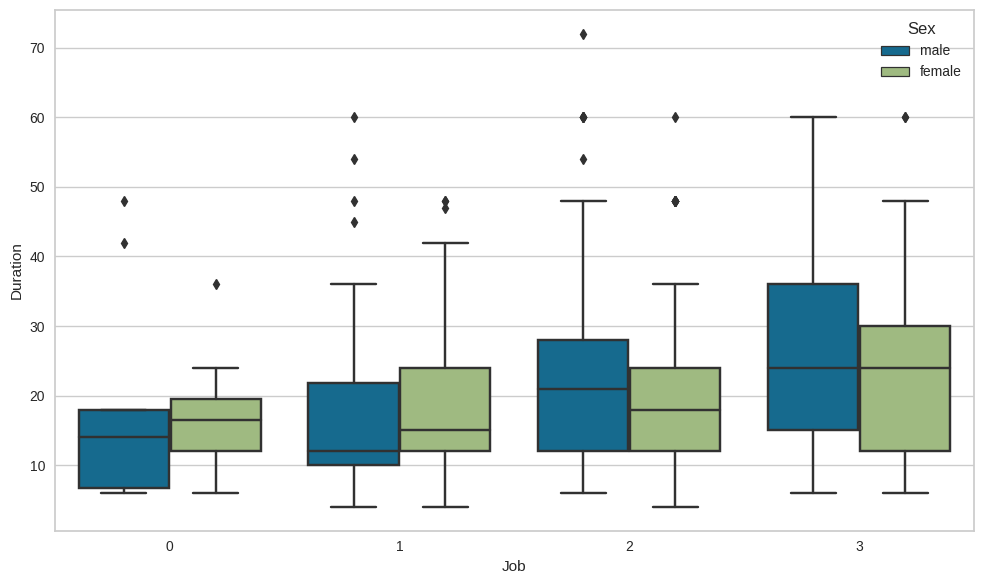

In [64]:
boxes("Job","Duration","Sex",r=0)

In terms of job category once again there is no difference between men and women, but we can see that job category 3 tends to take bigger credit amounts for longer duration.  

And at the end if someone likes 3D plots here you go.

Text(0.5, 0, 'Age')

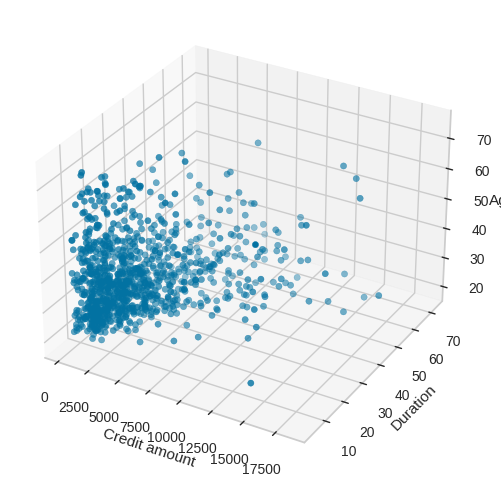

In [65]:
from mpl_toolkits.mplot3d import Axes3D 
fig = plt.figure(figsize=(10,6))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(data["Credit amount"], data["Duration"], data["Age"])
ax.set_xlabel("Credit amount")
ax.set_ylabel("Duration")
ax.set_zlabel("Age")

**Clustering with KMeans**

For clustering, I will create a subset containing only numerical variables (Age, Credit amount, Duration). 

In [66]:
#Selecting columns for clusterisation with k-means
selected_cols = ["Age","Credit amount", "Duration"]
cluster_data = data.loc[:,selected_cols]

I will create a function which plots three histograms - one for each variable. 

In [67]:
def distributions(df):
    fig, (ax1, ax2, ax3) = plt.subplots(3,1, figsize=(8,8))
    sns.distplot(df["Age"], ax=ax1)
    sns.distplot(df["Credit amount"], ax=ax2)
    sns.distplot(df["Duration"], ax=ax3)
    plt.tight_layout()

Let's look at the histograms.

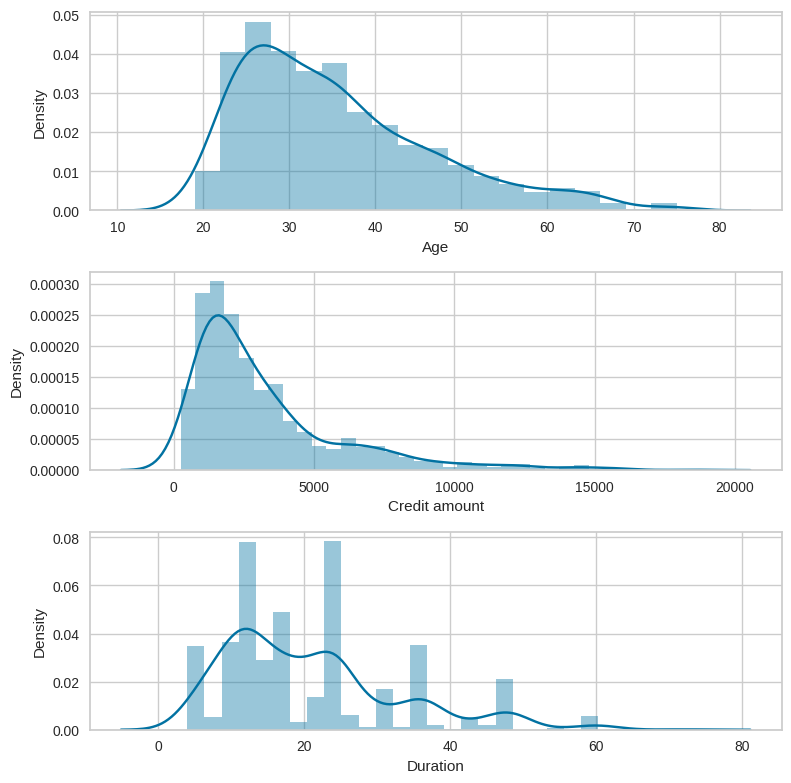

In [68]:
distributions(cluster_data)

We can see that distributions are right-skewed. To obtain better results we should remove the skewness by logarithmic transformation. After that let's see how they look like.

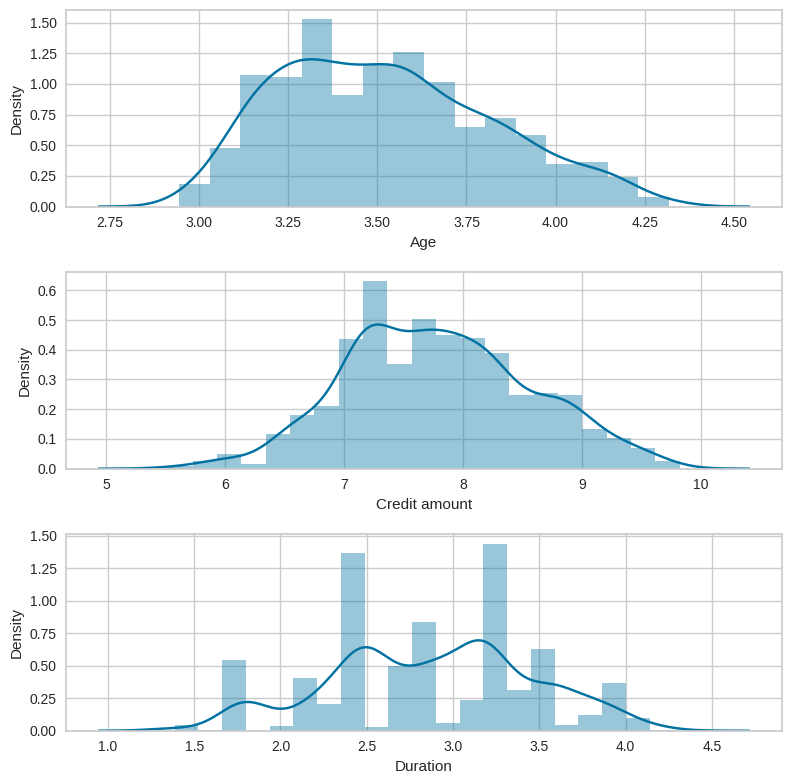

In [69]:
cluster_log = np.log(cluster_data)
distributions(cluster_log)

Indeed, the skewness has been eliminated. 

The next step will be centering and scaling of variables – it is required by KMeans algorithm.  We will use for that a StandardScaler from sklearn library. 

In [70]:
scaler = StandardScaler()
cluster_scaled = scaler.fit_transform(cluster_log)

I will check how inertia changes for various number of clusters.

In [86]:
# Measure execution time of small code snippets
from timeit import default_timer as timer

The execution time of elbow method was : 0.90 seconds


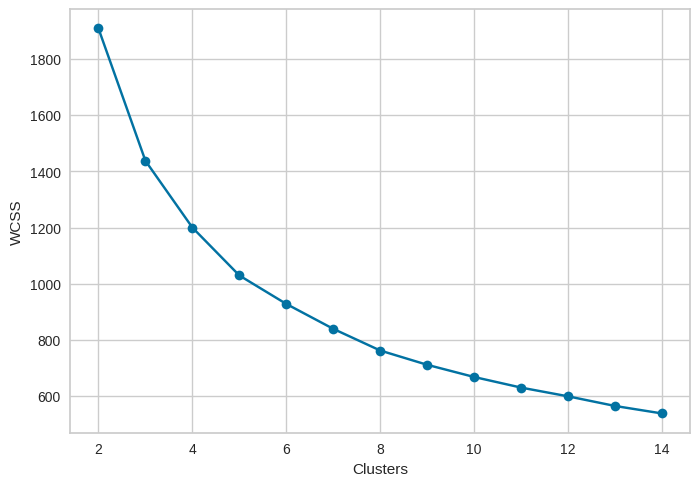

In [91]:
clusters_range = [2,3,4,5,6,7,8,9,10,11,12,13,14]
inertias =[]

# Starting measurement of the execution time of the code snippet corresponding to the obtaining the cluster number by elbow method
start = timer()

for c in clusters_range:
    kmeans = KMeans(n_clusters=c, random_state=0).fit(cluster_scaled)
    inertias.append(kmeans.inertia_)
    
# Finishing measurement of the execution time of the code snippet corresponding to the obtaining the cluster number by elbow method
end = timer()
Zeit = end - start
print(f"The execution time of elbow method was : {Zeit:.2f} seconds")    


plt.figure()
plt.plot(clusters_range,inertias, marker='o')
plt.xlabel('Clusters')
plt.ylabel('WCSS');
#  Within-Cluster-Sum-of-Squares (WCSS). WCSS is the sum of squares of the distances of each data point in all clusters to their respective centroids.

The plot above shows that inertia decreases with increasing number of clusters. 

This method allows for assessment of cluster separations and fitting of each observation in its own cluster.  The highest score the better.  I will perform this analysis for various seeds as well.

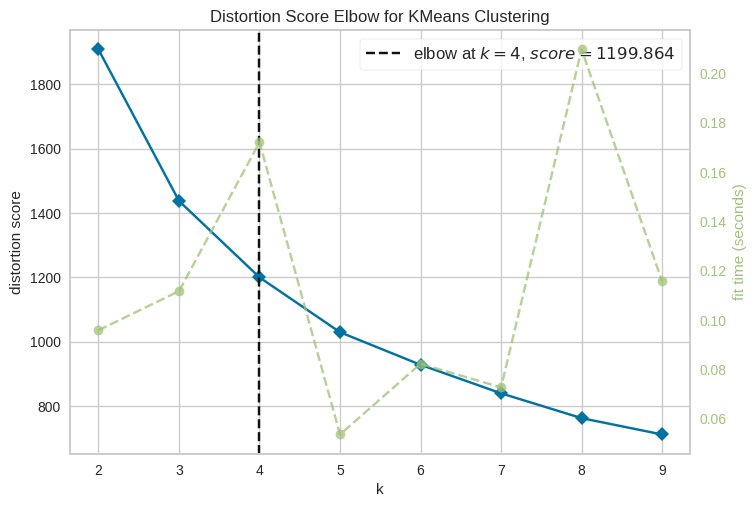

In [72]:
# There are other elegant form to visualize the elbow method using the Yellowbrick (i.e. Machine Learning Visualization Module)
from yellowbrick.cluster import KElbowVisualizer

visualizer = KElbowVisualizer(kmeans, k=(2,10))
# In the visualizer “elbow” will be annotated with a dashed line.

visualizer.fit(cluster_scaled)
visualizer.show()
plt.show()

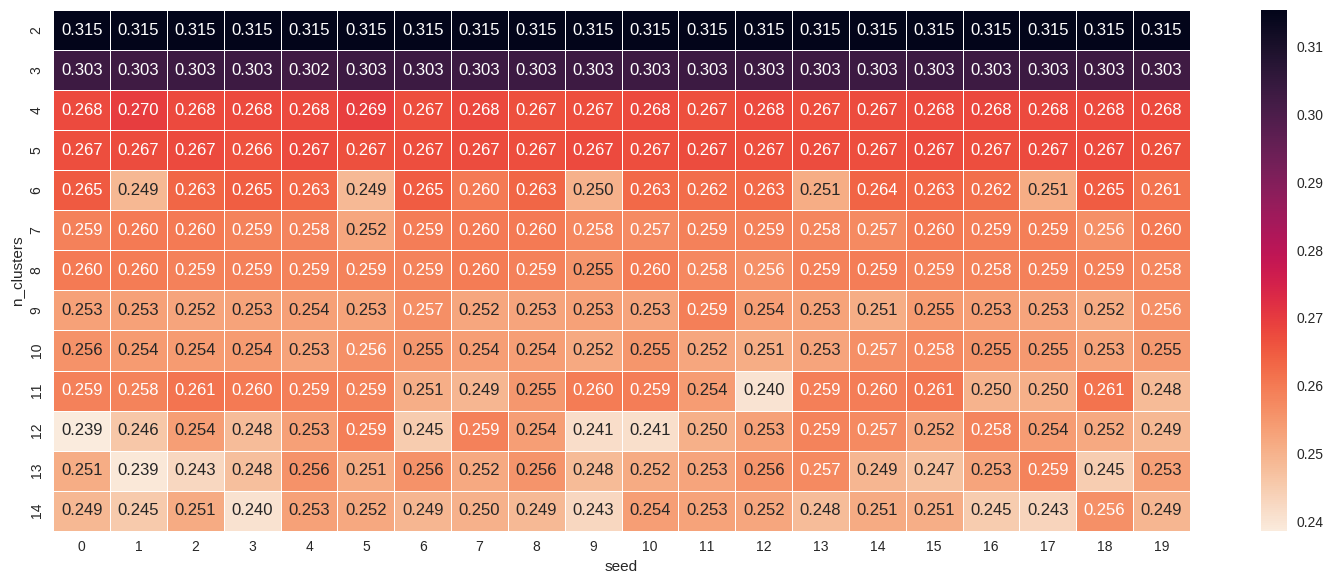

In [73]:
from sklearn.metrics import silhouette_samples, silhouette_score

clusters_range = range(2,15)
random_range = range(0,20)
results =[]
for c in clusters_range:
    for r in random_range:
        clusterer = KMeans(n_clusters=c, random_state=r)
        cluster_labels = clusterer.fit_predict(cluster_scaled)
        silhouette_avg = silhouette_score(cluster_scaled, cluster_labels)
        #print("For n_clusters =", c," and seed =", r,  "\nThe average silhouette_score is :", silhouette_avg)
        results.append([c,r,silhouette_avg])

result = pd.DataFrame(results, columns=["n_clusters","seed","silhouette_score"])
pivot_km = pd.pivot_table(result, index="n_clusters", columns="seed",values="silhouette_score")

plt.figure(figsize=(15,6))
sns.heatmap(pivot_km, annot=True, linewidths=.5, fmt='.3f', cmap=sns.cm.rocket_r)
plt.tight_layout()

The heatmap above shows silhouette scores for various combinations of random state and number of clusters. The highest scores are for 2 and 3 clusters and they are relatively insensitive to seed. 

I will chose 3 clusters to get more insight into data.

In [89]:
# Starting measurement of the execution time of the code snippet corresponding to the clustering performed by k-means
start = timer()

kmeans_sel = KMeans(n_clusters=3, random_state=1).fit(cluster_scaled)
labels = pd.DataFrame(kmeans_sel.labels_)
clustered_data = cluster_data.assign(Cluster=labels) # cluster_data are data before logarithm transformation
# assign(). Assign new columns to a DataFrame.

# Finishing measurement of the execution time of the code snippet corresponding to the clustering performed by k-means
end = timer()
Zeit = end - start
print(f"The execution time of K-means clustering was : {Zeit:.2f} seconds")    
# Nevertheless, it is important to consider also the obtaining of the cluster numbers by elbow method

The execution time of K-means clustering was : 0.10 seconds


Below I will create silhouette graph for 3 clusters in order to visually depict fit of each point within its own cluster (modified code from scikit-learn doc).

In [75]:
# matplotlib.cm. This module provides a large set of colormaps, functions for registering new colormaps and for getting a colormap by name, and a mixin class for adding color mapping functionality. 

In [76]:
# nipy_spectral(). Set the colormap to 'nipy_spectral'.
# This changes the default colormap as well as the colormap of the current image if there is one. 

For n_clusters = 3  and seed = 19 
The average silhouette_score is : 0.30255813750380023


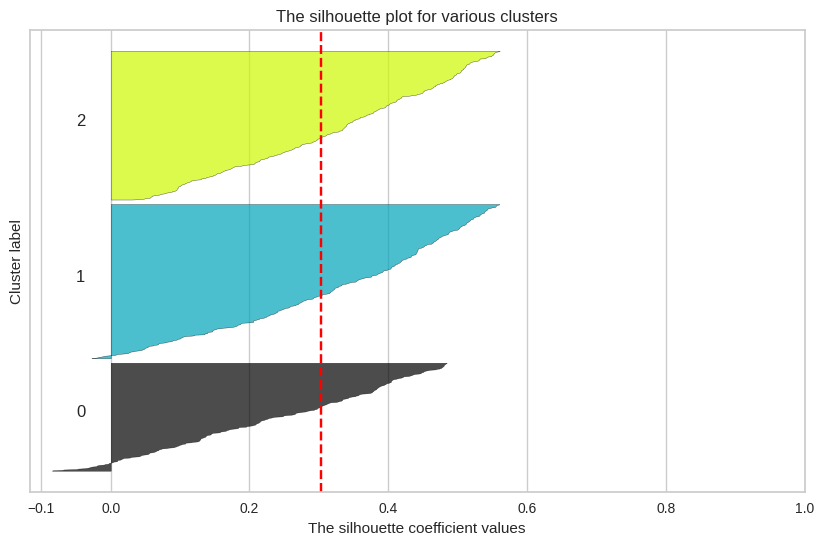

In [77]:
import matplotlib.cm as cm

clusterer = KMeans(n_clusters=3, random_state=1)
cluster_labels = clusterer.fit_predict(cluster_scaled)
silhouette_avg = silhouette_score(cluster_scaled, cluster_labels)
print("For n_clusters =", 3," and seed =", r,  "\nThe average silhouette_score is :", silhouette_avg)

# silhouette_samples(). Compute the silhouette scores for each sample
sample_silhouette_values = silhouette_samples(cluster_scaled, cluster_labels)

fig, ax1 = plt.subplots(figsize=(10,6))

y_lower = 10
for i in range(3):
    # Aggregate the silhouette scores for samples belonging to
    # cluster i, and sort them
    ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]
    ith_cluster_silhouette_values.sort()

    size_cluster_i = ith_cluster_silhouette_values.shape[0]
    y_upper = y_lower + size_cluster_i
    
    color = cm.nipy_spectral(float(i) / 3)
    # fill_betweenx(). Fill the area between two vertical curves.
    ax1.fill_betweenx(np.arange(y_lower, y_upper),0, ith_cluster_silhouette_values, facecolor=color, edgecolor="black", alpha=0.7)
    
    # Label the silhouette plots with their cluster numbers at the middle
    ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))
    
    # Compute the new y_lower for next plot
    y_lower = y_upper + 10  # 10 for the 0 samples

ax1.get_yaxis().set_ticks([]) # set_ticks(). Set this Axis' tick locations and optionally labels.
ax1.set_title("The silhouette plot for various clusters")
ax1.set_xlabel("The silhouette coefficient values")
ax1.set_ylabel("Cluster label")
# The vertical line for average silhouette score of all the values
ax1.axvline(x=silhouette_avg, color="red", linestyle="--") # Add a vertical line across the Axes.
ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

I will define a function showing clusters on the scatter plot.  

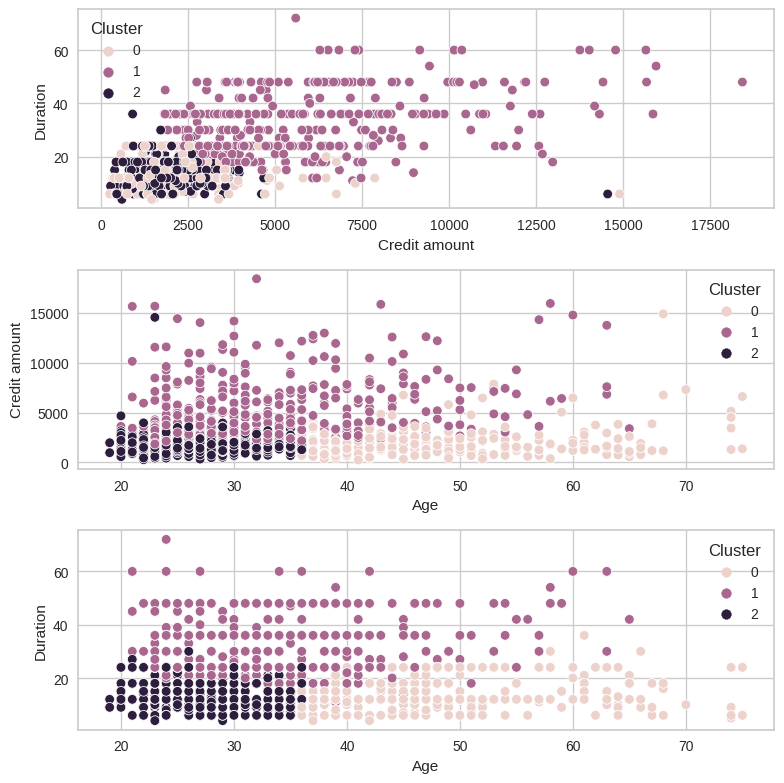

In [78]:
scatters(clustered_data, 'Cluster')

Plots above show three created clusters. Two bottom ones show relatively clear separation of clusters, but it is no so evident on the top one. 

I will generate now a heatmap plot for easier business interpretation of customer segmentation.  

In [79]:
grouped_km = clustered_data.groupby(['Cluster']).mean().round(1)
grouped_km

,Age,Credit amount,Duration
Cluster,,,
0,48.5,1970.3,13.9
1,34.0,5665.4,32.2
2,27.7,1736.3,14.3


Cluster 0 –  lower mean of credit amount, short duration, older customers

Cluster 1 – high mean of credit amount, long duration, middle-aged customers

Cluster 2 - lower mean of credit amount, short duration, young customers

**Clustering with Affinity Propagation**

In this algorithm there are two relevant parameters: preference and dumping. It means that we don’t define upfront number of clusters, algorithm itself chooses their number. I will fix dumping and check number of clusters in function of preference parameter.  

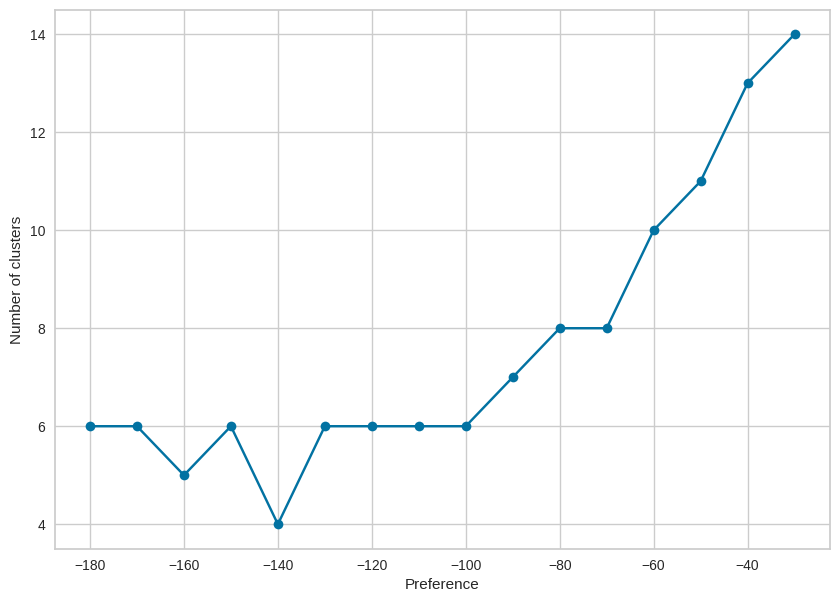

In [80]:
preferences = np.arange(-30,-190,-10) # arange() Return evenly spaced values within a given interval.
clusters = []

for p in preferences:
    af = AffinityPropagation(preference=p, damping=0.6, max_iter=400, verbose=False).fit(cluster_scaled)
    labels_af = pd.DataFrame(af.labels_)
    clusters.append(len(af.cluster_centers_indices_))
    # Verbose is a general programming term for produce lots of logging output.

plt.figure(figsize=(10,7))
plt.xlabel("Preference")
plt.ylabel("Number of clusters")
plt.plot(preferences,clusters, marker='o')


Together with decreasing value of preference parameter number of clusters goes down as well and levels for very small preference values. I will check four clusters option. 

The execution time of Affinity Propagation clustering was : 1.12 seconds


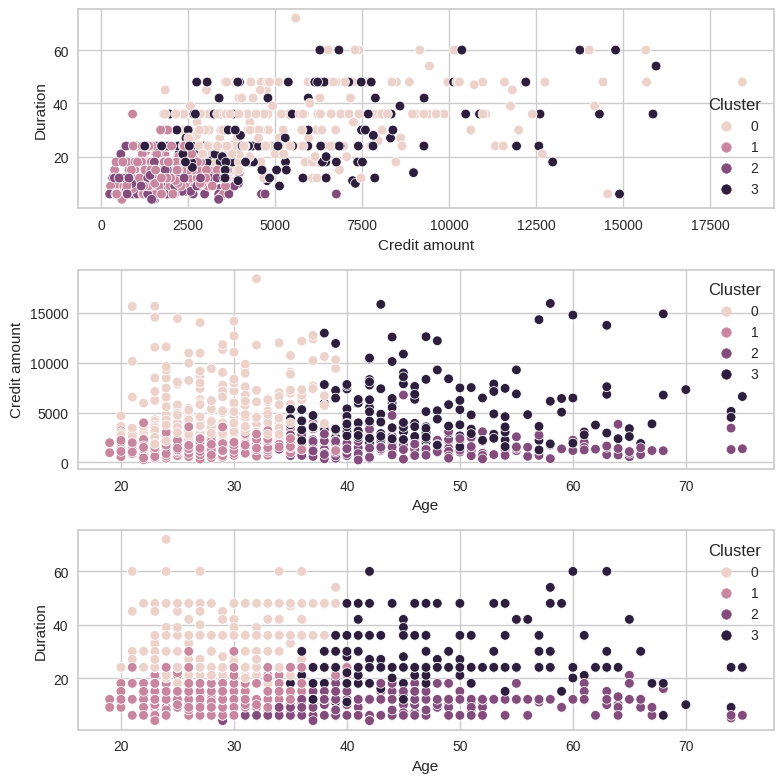

In [90]:
# Starting measurement of the execution time of the code snippet corresponding to the clustering performed by Affinity Propagation
start = timer()

af = AffinityPropagation(preference=-140, damping=0.6, verbose=False).fit(cluster_scaled)
labels_af = pd.DataFrame(af.labels_)

# Finishing measurement of the execution time of the code snippet corresponding to the clustering performed by Affinity Propagation
end = timer()
Zeit = end - start
print(f"The execution time of Affinity Propagation clustering was : {Zeit:.2f} seconds")    

# This allows the identified clusters to be calculated.
n_clusters_ = len(af.cluster_centers_indices_)

clustered_data_af = cluster_data.assign(Cluster=labels_af)
scatters(clustered_data_af,'Cluster')

In [82]:
grouped_af = clustered_data_af.groupby(['Cluster']).mean().round(1)
grouped_af

,Age,Credit amount,Duration
Cluster,,,
0,28.7,5593.7,32.2
1,27.9,1654.3,15.1
2,46.0,1551.7,10.7
3,47.5,4977.9,27.6


Cluster 0 – high mean of credit amount, long duration, younger customers

Cluster 1 – low mean of credit amount, short duration, younger customers

Cluster 2 - low mean of credit amount, short duration, older customers

Cluster 3 - high mean of credit amount, middle-time duration, older customers